Adapted from https://pennylane.ai/qml/demos/tutorial_spsa.html

In [15]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
from math import prod
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def StronglyEntanglingLayers(qubits, num_layers):
    c = cirq.Circuit()
    num_qubits = len(qubits)
    num_params = num_qubits * 3 * num_layers
    params = sympy.symbols("q0:%d"%num_params)
    counter = 0
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            c += cirq.ry(params[counter]).on(qubits[qubit])
            c += cirq.rz(params[counter + 1]).on(qubits[qubit])
            c += cirq.ry(params[counter + 2]).on(qubits[qubit])
            counter += 3
        for qubit in range(num_qubits - 1):
            c += cirq.CNOT(qubits[qubit], qubits[qubit + 1])
        c += cirq.CNOT(qubits[num_qubits - 1], qubits[0])
    return c, params

def make_model(circuit, params, op):
    inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=42)
    layer1 = tfq.layers.PQC(circuit, op, repetitions=1_000, \
                            differentiator=tfq.differentiators.ParameterShift(), initializer=init)(inputs)
    vqc = tf.keras.models.Model(inputs=inputs, outputs=layer1)
    return vqc

In [17]:
def ps_learning(model):
    max_iter = 15
    i = 0
    tol = 1e-5
    inputs = tfq.convert_to_tensor([cirq.Circuit()])
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)
    es = [1e10]
    while i < max_iter:
        with tf.GradientTape() as tape:
            energy = model(inputs)
        grads = tape.gradient(energy, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        es.append(energy.numpy()[0])
        if abs(es[-2] - es[-1]) < tol:
            break
        i += 1
    return es[1:]

from spsa import minimize

def spsa_learning(model):
    #tfq.optimizers.spsa_minimize
    inputs = tfq.convert_to_tensor([cirq.Circuit()])
    def f(x):
        model.set_weights([x])
        return model(inputs)[0][0]
    init_params = tf.convert_to_tensor(np.random.normal(scale=0.1, size=(model.trainable_variables[0].shape[0])),\
                                       dtype=tf.float32)
    log, es = minimize(f, init_params, max_iterations=300, alpha=0.2, perturb=0.15, \
                       lr=0.05 * ((200 * 0.1) + 1) ** 0.2)
    return es.history[:log.num_iterations]

In [18]:
num_wires = 4
num_layers = 5
qubits = [cirq.GridQubit(0, i) for i in range(num_wires)]
op = prod([cirq.Z(i) for i in qubits])

model1 = make_model(*StronglyEntanglingLayers(qubits, num_layers), op=op)
model2 = make_model(*StronglyEntanglingLayers(qubits, num_layers), op=op)

In [19]:
spsa_es = spsa_learning(model1)
grad_es = ps_learning(model2)

In [20]:
xs = np.arange(len(spsa_es)) * 2
xs1 = np.arange(len(grad_es)) * (2 * num_wires * num_layers * 3)

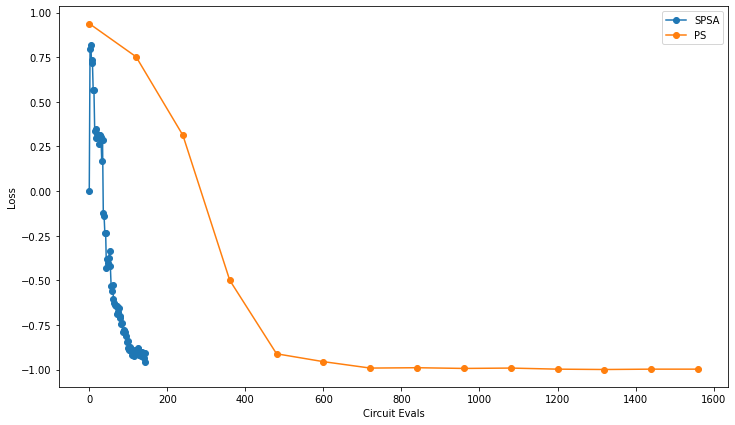

In [23]:
fig = plt.figure(figsize=(12, 7))
plt.plot(xs, spsa_es, label='SPSA', marker='o')
#plt.plot(spsa_es, label='SPSA', marker='o')
#plt.plot(grad_es, label='PS', marker='o')
plt.plot(xs1, grad_es, label='PS', marker='o')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Circuit Evals")
plt.show()